<a href="https://colab.research.google.com/github/esds-fiocruz/regressao_logistisca_abandono_tuberculose/blob/main/modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Download das biblioteca do PySUS
!pip install pysus
!pip install --upgrade openpyxl

In [ ]:
#Importação das bibliotecas
import os
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as st
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import linear_model
from pysus.ftp.databases.sinan import SINAN
from math import nan
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

In [ ]:
#Carregando as informações do SINAN
sinan = SINAN().load()
files = sinan.get_files(dis_code="TUBE", year=[2022, 2021, 2020, 2019])
tube_2022, tube_2021 , tube_2020, tube_2019  = files

In [ ]:
sinan.describe(tube_2022)

{'name': 'TUBEBR19.dbc',
 'disease': 'Tuberculose',
 'year': 2019,
 'size': '5.2 MB',
 'last_update': '2024-04-22 04:23PM'}

In [ ]:
#Criando DataFrame
df = pd.DataFrame()

In [ ]:
# Gerando a estruta de arquivos e obtendo os dados do SINAM
lista_tub = [tube_2022, tube_2021, tube_2020, tube_2019]
for tub in lista_tub:
   nome = str(tub)
   ano = nome[6:8]
   if not os.path.isfile(f'./TUB_CN/20{ano}/TUB_CN_20{ano}.csv'):
      os.makedirs(f"./TUB_CN/20{ano}")
      parquet = tub.download()
      df_new = parquet.to_dataframe()
      df_new.to_csv(f'./TUB_CN/20{ano}/TUB_CN_20{ano}.csv', index=False)
      df_temp = pd.read_csv(f'./TUB_CN/20{ano}/TUB_CN_20{ano}.csv', index_col=False, low_memory=False)
      df = pd.concat([df, df_temp])
df.shape

(378297, 97)

###Limpeza e Tratamento dos Dados

In [ ]:
#### TRATAMENTO DE VARIÁVEIS NÃO UTILIZADAS E NULAS ####
df_temp = df.copy()
df_temp = df_temp.reset_index(drop=True)
columns = ['CS_SEXO', 'NU_IDADE_N', 'CS_RACA', 'CS_ESCOL_N', 'POP_LIBER',
       'POP_RUA', 'POP_SAUDE', 'POP_IMIG', 'BENEF_GOV', 'AGRAVDROGA',
       'AGRAVALCOO', 'AGRAVTABAC', 'AGRAVDIABE', 'AGRAVDOENC', 'AGRAVOUTRA',
       'FORMA', 'HIV', 'TRATSUP_AT', 'SITUA_ENCE']
df_temp = df_temp[columns]
df_temp = df_temp[df_temp["SITUA_ENCE"].isin([1,2,3])]
df_temp = df_temp.reset_index(drop=True)

#### SEXO #####
df_geral = df_temp.copy()
df_geral.replace({"CS_SEXO": {"F": 1, "M": 2, "I":nan}}, inplace=True)
df_geral['CS_SEXO'] = df_geral['CS_SEXO'].astype('float')

### IDADE ###
df_geral["NU_IDADE_N"] = pd.cut(df_geral["NU_IDADE_N"],
                                  bins=[-np.inf, 4019, 4039, 4059, np.inf],
                                  labels=[1, 2, 3, 4])
### RAÇA ###
df_geral.replace({"CS_RACA": {9:nan}}, inplace=True)
df_geral["CS_RACA"] = np.where(df_geral["CS_RACA"].between(2,5), 2, df_geral["CS_RACA"])

### ESCOLARIDADE ###
df_geral.replace({"CS_ESCOL_N": {9:nan, 10:nan}}, inplace=True)
df_geral["CS_ESCOL_N"] = pd.cut(df_geral["CS_ESCOL_N"], bins=[-np.inf, 0, 4,8,9,np.inf],
                                  labels=[1,2,3,4,5])
df_geral.replace({"CS_ESCOL_N": {4:nan, 5:nan}}, inplace=True)

### PRISIONEIROS ####
df_geral.replace({"POP_LIBER": {9:nan}}, inplace=True)

### POP_RUA ####
df_geral.replace({"POP_RUA": {9:nan}}, inplace=True)

### POP_SAUDE ####
df_geral.replace({"POP_SAUDE": {9:nan}}, inplace=True)

### POP_IMIG ####
df_geral.replace({"POP_IMIG": {9:nan, 3:nan}}, inplace=True)

### BENEF_GOV ####
df_geral.replace({"BENEF_GOV": {9:nan, 3:nan, 4:nan, 5:nan, 7:nan, 8:nan}}, inplace=True)

### DROGRAS ILÍCITAS ###
df_geral.replace({"AGRAVDROGA": {9:nan}}, inplace=True)

### TABACO ###
df_geral.replace({"AGRAVTABAC": {9:nan}}, inplace=True)

### Alcoolismo ###
df_geral.replace({"AGRAVALCOO": {9:nan}}, inplace=True)

### DIABETES ###
df_geral.replace({"AGRAVDIABE": {9:nan}}, inplace=True)

### DOENCAS MENTAIS ###
df_geral.replace({"AGRAVDOENC": {9:nan}}, inplace=True)

### Outras Doenças ###
df_geral.replace({"AGRAVOUTRA": {9:nan}}, inplace=True)

### FORMAS ####

### HIV ###
df_geral.replace({"HIV": {4:nan,}}, inplace=True)

### SUPERVISIONADO ###
df_geral.replace({"TRATSUP_AT": {9:nan,}}, inplace=True)

df_aux = df_geral.copy()

In [ ]:
df_geral = df_geral.dropna()
df_geral.reset_index(drop=True, inplace=True)
df_geral.shape

(79929, 19)

###Conversão do Dataframe para variáveis dummies


https://stats.oarc.ucla.edu/wp-content/uploads/2016/02/p046.pdf


In [ ]:
#Criando variáveis Dummies
def convert_in_dummies(df_aux, column ,new_columns, drop_column_name,):
    df_temp = pd.get_dummies(df_aux[column], dtype=int)
    df_temp.rename(columns=new_columns, inplace=True)
    df_temp.drop(columns=[drop_column_name], inplace=True)
    df_aux = pd.concat([df_aux, df_temp], axis=1)
    df_aux.drop(columns=[column], inplace=True)
    return df_aux

In [ ]:
df_geral = convert_in_dummies(df_geral, "CS_SEXO", {2:"MASCULINO", 1:"FEMININO"}, "FEMININO")
df_geral = convert_in_dummies(df_geral, "NU_IDADE_N", {1: "<=19", 2: "20_39", 3:"40_59", 4:"60+"}, "<=19")
df_geral = convert_in_dummies(df_geral, "CS_RACA", {1: "BRANCO", 2:"NÃO_BRANCO"}, "BRANCO")
df_geral = convert_in_dummies(df_geral, "CS_ESCOL_N",{1: "SEM_ESCOLARIDADE", 2: "<=8_ANOS", 3:">8_ANOS"}, ">8_ANOS")
df_geral = convert_in_dummies(df_geral, "POP_LIBER", {1:"PRISIONEIRO", 2:"NÃO_PRISIONEIRO"}, "NÃO_PRISIONEIRO")
df_geral = convert_in_dummies(df_geral, "POP_RUA", {1:"MORADOR_DE_RUA", 2:"NÃO_MORADOR_DE_RUA"}, "NÃO_MORADOR_DE_RUA")
df_geral = convert_in_dummies(df_geral,"POP_SAUDE", {1:"PROFISSIONAL_DA_SAUDE", 2:"NÃO_PROFISSIONAL_DA_SAUDE"}, "NÃO_PROFISSIONAL_DA_SAUDE")
df_geral = convert_in_dummies(df_geral,"POP_IMIG", {1:"IMIGRANTE", 2:"NÃO_IMIGRANTE"}, "NÃO_IMIGRANTE")
df_geral = convert_in_dummies(df_geral,"BENEF_GOV", {1:"BENEFICIARIO", 2:"NÃO_BENEFICIARIO"}, "NÃO_BENEFICIARIO")
df_geral = convert_in_dummies(df_geral,"AGRAVDROGA", {1:"DROGAS_ILICITAS", 2:"NÃO_DROGAS_ILICITAS"}, "NÃO_DROGAS_ILICITAS")
df_geral = convert_in_dummies(df_geral,"AGRAVALCOO", {1:"ALCOOL", 2:"NÃO_ALCOOL"}, "NÃO_ALCOOL")
df_geral = convert_in_dummies(df_geral,"AGRAVTABAC", {1:"TABACO", 2:"NÃO_TABACO"}, "NÃO_TABACO")
df_geral = convert_in_dummies(df_geral,"AGRAVDIABE", {1:"DIABETES", 2:"NÃO_DIABETES"}, "NÃO_DIABETES")
df_geral = convert_in_dummies(df_geral,"AGRAVDOENC", {1:"MENTAL", 2:"NÃO_MENTAL"}, "NÃO_MENTAL")
df_geral = convert_in_dummies(df_geral,"AGRAVOUTRA", {1:"OUTRAS_DOENCAS", 2:"NÃO_OUTRAS_DOENCAS"}, "NÃO_OUTRAS_DOENCAS")
df_geral = convert_in_dummies(df_geral,"FORMA", {1: "PULMONAR", 2: "EXTRA_PULMONAR", 3:"PULMONAR_EXTRA_PULMONAR"}, "PULMONAR")
df_geral = convert_in_dummies(df_geral,"HIV", {1: "HIV_POSITIVO", 2: "HIV_NEGATIVO", 3:"HIV_EM_ANDAMENTO"}, "HIV_NEGATIVO")
df_geral = convert_in_dummies(df_geral,"TRATSUP_AT", {1:"SUPERVISIONADO", 2:"NÃO_SUPERVISIONADO"}, "NÃO_SUPERVISIONADO")
df_geral = convert_in_dummies(df_geral,"SITUA_ENCE", {1:"NÃO_ABANDONO", 2:"ABANDONO", 3:"NÃO_ABANDONO"}, "NÃO_ABANDONO")

In [ ]:
#Variáveis Dummies
df_geral.columns

Index(['MASCULINO', '20_39', '40_59', '60+', 'NÃO_BRANCO', 'SEM_ESCOLARIDADE',
       '<=8_ANOS', 'PRISIONEIRO', 'MORADOR_DE_RUA', 'PROFISSIONAL_DA_SAUDE',
       'IMIGRANTE', 'BENEFICIARIO', 'DROGAS_ILICITAS', 'ALCOOL', 'TABACO',
       'DIABETES', 'MENTAL', 'OUTRAS_DOENCAS', 'EXTRA_PULMONAR',
       'PULMONAR_EXTRA_PULMONAR', 'HIV_POSITIVO', 'HIV_EM_ANDAMENTO',
       'SUPERVISIONADO', 'ABANDONO'],
      dtype='object')

In [12]:
df_geral.head()

,MASCULINO,20_39,40_59,60+,NÃO_BRANCO,SEM_ESCOLARIDADE,<=8_ANOS,PRISIONEIRO,MORADOR_DE_RUA,PROFISSIONAL_DA_SAUDE,...,TABACO,DIABETES,MENTAL,OUTRAS_DOENCAS,EXTRA_PULMONAR,PULMONAR_EXTRA_PULMONAR,HIV_POSITIVO,HIV_EM_ANDAMENTO,SUPERVISIONADO,ABANDONO
0,1,1,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,1
1,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,1,1,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
3,1,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0


###Verificação da correlação das variáveis

In [13]:
### Verificando a correlação das variáveis usando variance inflation factor ####
y = df_geral["ABANDONO"]
X = df_geral.drop(columns=["ABANDONO"])

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                    feature       VIF
0                 MASCULINO  3.242061
1                     20_39  3.415592
2                     40_59  2.881266
3                       60+  1.960882
4                NÃO_BRANCO  3.142147
5          SEM_ESCOLARIDADE  1.218193
6                  <=8_ANOS  2.624879
7               PRISIONEIRO  1.297712
8            MORADOR_DE_RUA  1.122114
9     PROFISSIONAL_DA_SAUDE  1.055009
10                IMIGRANTE  1.013750
11             BENEFICIARIO  1.164369
12          DROGAS_ILICITAS  1.757585
13                   ALCOOL  1.604850
14                   TABACO  1.839908
15                 DIABETES  1.214604
16                   MENTAL  1.043998
17           OUTRAS_DOENCAS  1.198490
18           EXTRA_PULMONAR  1.149450
19  PULMONAR_EXTRA_PULMONAR  1.038055
20             HIV_POSITIVO  1.133041
21         HIV_EM_ANDAMENTO  1.003812
22           SUPERVISIONADO  1.899330


###Balanceamento dos dados


In [14]:
## Verificando a proporção entre as variáveis ##
df_t = y.value_counts().to_frame()
print(round((df_t.iloc[0,0]/df_t.sum())*100,2))
print(round((df_t.iloc[1,0]/df_t.sum())*100,2))

count    84.99
dtype: float64
count    15.01
dtype: float64


In [15]:
### Quantidade de pacientes que abandoram e não abandoram o tratamento ####
y.value_counts()

,count
ABANDONO,
0,67929
1,12000


In [16]:
## Equilibrando a variável resposta ##
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X, y)
y_res.value_counts()

,count
ABANDONO,
0,12000
1,12000


###Treinamento e Teste do modelo

In [20]:
## Treinando o modelo e usando o backward holdout
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

def backward_elimination(X, y, significance_level=0.05):
    variables = list(X.columns)
    while len(variables) > 0:
        X_subset = X[variables]
        model = sm.Logit(y, X_subset)
        result = model.fit(disp=False)
        p_values = result.pvalues
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            remove_var_name = p_values.idxmax()
            if remove_var_name in variables:
                variables.remove(remove_var_name)
        else:
            break

    return variables, result

selected_vars, result = backward_elimination(X_train, y_train)
X_test_selected = X_test[selected_vars]
y_pred = result.predict(X_test_selected)
y_pred_binary = np.where(y_pred >0.5, 1, 0)
print(f'AIC: {result.aic}')
print(result.summary())

AIC: 20275.715886238722
                           Logit Regression Results                           
Dep. Variable:               ABANDONO   No. Observations:                16800
Model:                          Logit   Df Residuals:                    16782
Method:                           MLE   Df Model:                           17
Date:                Mon, 07 Oct 2024   Pseudo R-squ.:                  0.1310
Time:                        14:25:19   Log-Likelihood:                -10120.
converged:                       True   LL-Null:                       -11645.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MASCULINO                 0.2460      0.037      6.592      0.000       0.173       0.319
20_39                    -0.1243      0.045     -2.762      0.006      -0.

In [21]:
## Verificando o OR value
coefficients = result.params
conf_int = result.conf_int(alpha=0.05)

odds_ratios = np.exp(coefficients)
conf_int_odds_ratios = np.exp(conf_int)

odds_ratios_df = pd.DataFrame({
    'Odds Ratio': odds_ratios,
    'CI Lower Bound': conf_int_odds_ratios[0],
    'CI Upper Bound': conf_int_odds_ratios[1]
}, index=selected_vars)

print(odds_ratios_df.sort_values(by='Odds Ratio', ascending=False))

                       Odds Ratio  CI Lower Bound  CI Upper Bound
MORADOR_DE_RUA           3.551978        2.897799        4.353837
DROGAS_ILICITAS          2.167484        1.965469        2.390262
HIV_POSITIVO             1.734193        1.544555        1.947114
<=8_ANOS                 1.445988        1.346544        1.552776
SEM_ESCOLARIDADE         1.348805        1.131117        1.608387
TABACO                   1.339609        1.232578        1.455933
ALCOOL                   1.280779        1.167251        1.405348
MASCULINO                1.278848        1.188659        1.375881
NÃO_BRANCO               1.112119        1.036672        1.193058
OUTRAS_DOENCAS           0.889744        0.797143        0.993104
20_39                    0.883080        0.808509        0.964529
DIABETES                 0.692827        0.606026        0.792059
EXTRA_PULMONAR           0.657527        0.584957        0.739100
40_59                    0.534613        0.482897        0.591867
PROFISSION

Text(0.5, 427.9555555555555, 'Real')

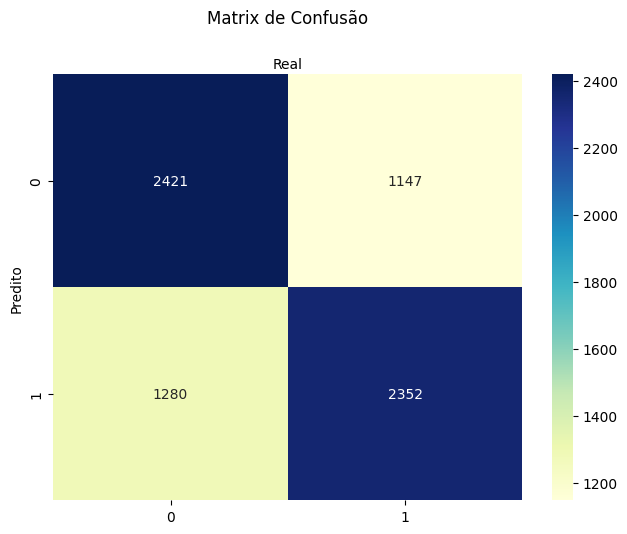

In [22]:
cnf_matrix = confusion_matrix(y_test, y_pred_binary)

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matrix de Confusão', y=1.1)
plt.ylabel('Predito')
plt.xlabel('Real')

###Curva ROC

0.5069388682809467


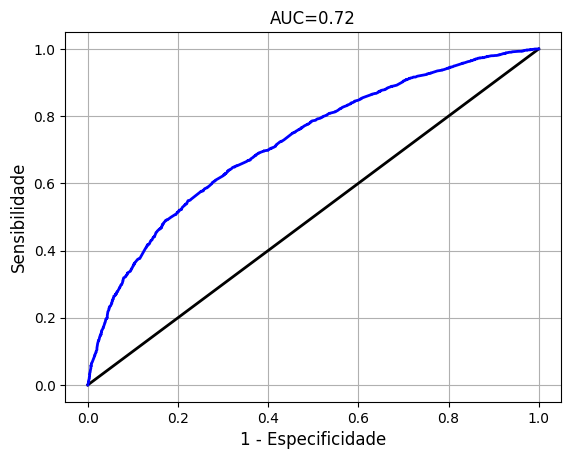

In [23]:
## Verificando a sensibilidade do modelo
fpr, tpr, thresholds  = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
optimal_idx_roc = np.argmax(tpr - fpr)
optimal_threshold_roc = thresholds[optimal_idx_roc]
print(optimal_threshold_roc)


plt.clf()
plt.grid(True)
plt.plot([0,1], [0,1], '-', color='black', lw=2)
plt.plot(fpr, tpr, '-', color='blue', lw=2)
plt.xlabel("1 - Especificidade", size=12)
plt.ylabel("Sensibilidade", size=12)
plt.title("AUC=%.2f" % auc)
plt.show()

In [24]:
target_names = ['NÃO_ABANDONO', 'ABANDONO']
print(classification_report(y_test, y_pred_binary, target_names=target_names))

              precision    recall  f1-score   support

NÃO_ABANDONO       0.65      0.68      0.67      3568
    ABANDONO       0.67      0.65      0.66      3632

    accuracy                           0.66      7200
   macro avg       0.66      0.66      0.66      7200
weighted avg       0.66      0.66      0.66      7200

